In [1]:
import pandas as pd
df_path_mion = './prep/experiments/mmu_dRNA_3T3_mion_1/joined_features_expanded_aggmax_cleaned.tab'
df_path_pion = './prep/experiments/mmu_dRNA_3T3_PION_1/joined_features_expanded_aggmax_cleaned.tab'

df_mion = pd.read_csv(df_path_mion, sep='\t', header=(0))
df_pion = pd.read_csv(df_path_pion, sep='\t', header=(0))
print(len(df_mion))
print(len(df_pion))
df = pd.concat([df_mion, df_pion])


2425
2593


In [2]:
df = df[df['t5'] != '--']


In [3]:
df['t5'] = pd.to_numeric(df['t5'])
# df = df[df['t5']<20]
df = df[df['t5']<30]

# df = df[df['t5']<12]

In [4]:
df['t5'].describe()

count    4955.000000
mean        3.704867
std         4.445661
min         0.100000
25%         0.816918
50%         2.138433
75%         4.701065
max        29.333347
Name: t5, dtype: float64

In [5]:
df = df.drop(['transcript','gene', 'transcript_id'], axis=1)

In [6]:
from sklearn.preprocessing import StandardScaler

def normalize_dataframes(train_df, test_df):
    scaler = StandardScaler()
    #compute statistics from my training dataframe
    scaler.fit(train_df)
    train_df_scaled = pd.DataFrame(
        scaler.transform(train_df), 
        columns=train_df.columns
    )
    test_df_scaled = pd.DataFrame(
        scaler.transform(test_df),
        columns=test_df.columns
    )
    return train_df_scaled, test_df_scaled


In [7]:
from scripts.splitting import train_test_split_df
train_df, test_df = train_test_split_df(df, verbose=True)

num of unique train genes 2231
num of unique test genes 558
num of train rows 4250
num of test rows 705


In [8]:
# df.describe()
train_df = train_df.drop(['name'], axis=1)
test_df = test_df.drop(['name'], axis=1)

In [9]:
X_train, y_train = train_df.drop('t5', axis=1), train_df[['t5']]
X_test, y_test = test_df.drop('t5', axis=1), test_df[['t5']]
X_train, X_test = normalize_dataframes(X_train, X_test)

In [10]:
# X_train.dtypes
y_train= y_train.astype(float)
y_test= y_test.astype(float)

In [11]:
import xgboost as xgb

dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=False)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=False)

In [12]:
# params = {
#     "objective": "reg:squarederror", 
#     "tree_method": "gpu_hist",
#     "max_depth": 3,
#     "reg_lambda":2,
#     "reg_alpha":2,
#     "num_parallel_tree":3,
#     # "booster":"gbtree",
#     # "booster":"dart",
#     "eta":0.01,
#     "subsample":0.5,
    
# }
params = {
    "objective": "reg:squarederror", 
    "tree_method": "gpu_hist",
    "max_depth": 3,
    "reg_lambda":2,
    "reg_alpha":2,
    "num_parallel_tree":3,
    # "booster":"gbtree",
    # "booster":"dart",
    "eta":0.01,
    "subsample":0.5,
    
}
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]
n = 500
xgboost_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=50,
    # eval_metric='mse',
    
)

[0]	train-rmse:5.53340	validation-rmse:4.90448
[50]	train-rmse:4.36069	validation-rmse:3.83836
[100]	train-rmse:3.75483	validation-rmse:3.35204
[150]	train-rmse:3.44825	validation-rmse:3.16069
[200]	train-rmse:3.28270	validation-rmse:3.07707
[250]	train-rmse:3.18835	validation-rmse:3.04728
[300]	train-rmse:3.12738	validation-rmse:3.03358
[350]	train-rmse:3.08291	validation-rmse:3.03109
[400]	train-rmse:3.04615	validation-rmse:3.02943
[450]	train-rmse:3.01538	validation-rmse:3.02857
[499]	train-rmse:2.98938	validation-rmse:3.03015


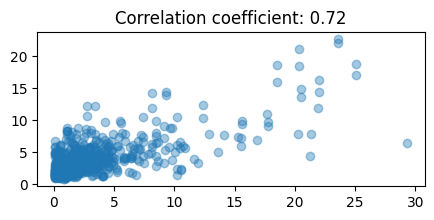

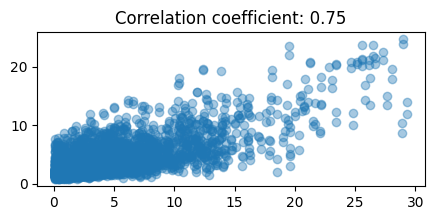

In [13]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np

def plot_stuff(data, labels, model):
    preds = model.predict(data)
    rmse = mean_squared_error(labels, preds, squared=True)
    # print(f"MSE of the base model: {rmse:.3f}")
    corr_coef = np.corrcoef(labels, preds)[0,1]
    plt.figure(figsize=(5,2))
    plt.title(f'Correlation coefficient: {corr_coef:.2f}')
    plt.scatter(labels, preds, alpha=0.4)
    plt.show()
    
plot_stuff(dtest_reg, y_test.values.flatten(),xgboost_model)
plot_stuff(dtrain_reg, y_train.values.flatten(),xgboost_model)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

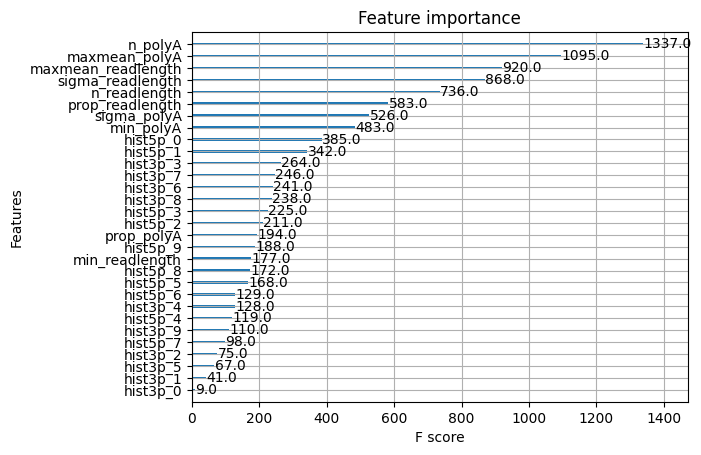

In [15]:
from xgboost import plot_importance
plot_importance(xgboost_model)

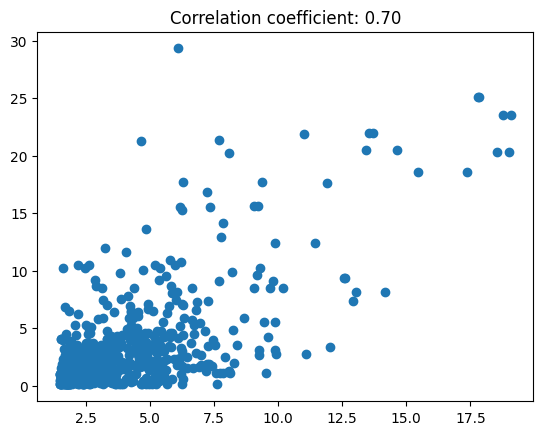

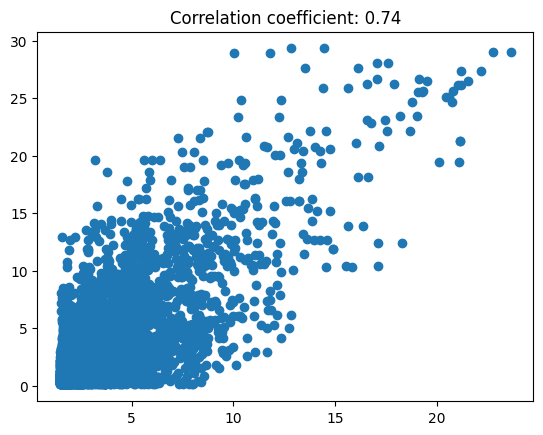

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=5, max_features=1.0, max_samples=0.5)

# Fit the model
rf.fit(X_train, y_train.values.ravel())

def plot_sci(model, X, y):
    y_pred = model.predict(X).reshape(-1,1)
    corr_coef = np.corrcoef(y_pred.flatten(), y.values.flatten())[0,1]
    plt.title(f'Correlation coefficient: {corr_coef:.2f}')
    plt.scatter(y_pred.flatten(), y.values.flatten())
    plt.show()
    
    
plot_sci(rf, X_test, y_test)
plot_sci(rf, X_train, y_train)